In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install --upgrade tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.68.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using 

In [9]:
import tensorflow as tf
print(tf.__version__)


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from tensorflow.keras import mixed_precision


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load and preprocess the CSV data
csv_path = '/Brain_MRI_Dataset/mri_dataset/Brain_MRI_conditions.csv'
csv_data = pd.read_csv(csv_path)

# Basic preprocessing of the CSV dataset
# Keep 'Type', 'Description', and 'Body Part' columns for now
csv_data = csv_data[['Type', 'Description', 'Body Part']]
csv_data.fillna('', inplace=True)

# Encode categorical columns
label_encoders = {}
for col in csv_data.columns:
    le = LabelEncoder()
    csv_data[col] = le.fit_transform(csv_data[col])
    label_encoders[col] = le

# Paths to the tumor and no tumor image folders
tumor_folders = ['/Brain_MRI_Dataset/Training/glioma', '/Brain_MRI_Dataset/Training/meningioma', '/Brain_MRI_Dataset/Training/pituitary']
no_tumor_folder = '/Brain_MRI_Dataset/Training/notumor'

# Function to load and preprocess images from a folder
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to 0-1 range
            images.append(img)
            labels.append(label)
    return images, labels

# Load tumor and no tumor images from multiple folders
X_images = []
y_labels = []

# Load tumor images from the 3 tumor folders
for tumor_folder in tumor_folders:
    tumor_images, tumor_labels = load_images_from_folder(tumor_folder, label=1)  # Label 1 for tumor
    X_images.extend(tumor_images)
    y_labels.extend(tumor_labels)

# Load no tumor images
no_tumor_images, no_tumor_labels = load_images_from_folder(no_tumor_folder, label=0)  # Label 0 for no tumor
X_images.extend(no_tumor_images)
y_labels.extend(no_tumor_labels)

# Convert lists to numpy arrays
X_images = np.array(X_images)
y_labels = np.array(y_labels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)

# Build a CNN model for image classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: cancer or no cancer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model
model.save('brain_mri_cancer_model.h5')

# To make predictions
def predict_cancer(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    if prediction > 0.5:
        return "Cancer"
    else:
        return "No Cancer"

# Example prediction
new_image_path = '/Brain_MRI_Dataset/Testing/glioma/Te-glTr_0000.jpg'
result = predict_cancer(new_image_path, model)
print(result)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7915 - loss: 0.4464 - val_accuracy: 0.9598 - val_loss: 0.1190
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9549 - loss: 0.1366 - val_accuracy: 0.9650 - val_loss: 0.1066
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9695 - loss: 0.1056 - val_accuracy: 0.9711 - val_loss: 0.0715
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9699 - loss: 0.0840 - val_accuracy: 0.9659 - val_loss: 0.1023
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9741 - loss: 0.0782 - val_accuracy: 0.9694 - val_loss: 0.0810
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9771 - loss: 0.0667 - val_accuracy: 0.9746 - val_loss: 0.0949
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9813 - loss: 0.0472 - val_accuracy: 0.9799 - val_loss: 0.0658
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9871 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Cancer


In [ ]:
new_image_path = 'Brain_MRI_Dataset/Testing/notumor/Te-noTr_0000.jpg'
result = predict_cancer(new_image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
No Cancer


In [ ]:
new_image_path = '/Brain_MRI_Dataset/Testing/glioma/Te-gl_0294.jpg'
result = predict_cancer(new_image_path, model)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Cancer


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.9873 - loss: 0.0330 - val_accuracy: 0.9834 - val_loss: 0.0852
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9848 - loss: 0.0313 - val_accuracy: 0.9834 - val_loss: 0.0879
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.9865 - loss: 0.0346 - val_accuracy: 0.9816 - val_loss: 0.0945
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9926 - loss: 0.0166 - val_accuracy: 0.9825 - val_loss: 0.1175
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9928 - loss: 0.0153 - val_accuracy: 0.9808 - val_loss: 0.1777
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9880 - loss: 0.0254 - val_accuracy: 0.9834 - val_loss: 0.1078
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.9949 - loss: 0.0137 - val_accuracy: 0.9860 - val_loss: 0.1148
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9964 - loss: 0

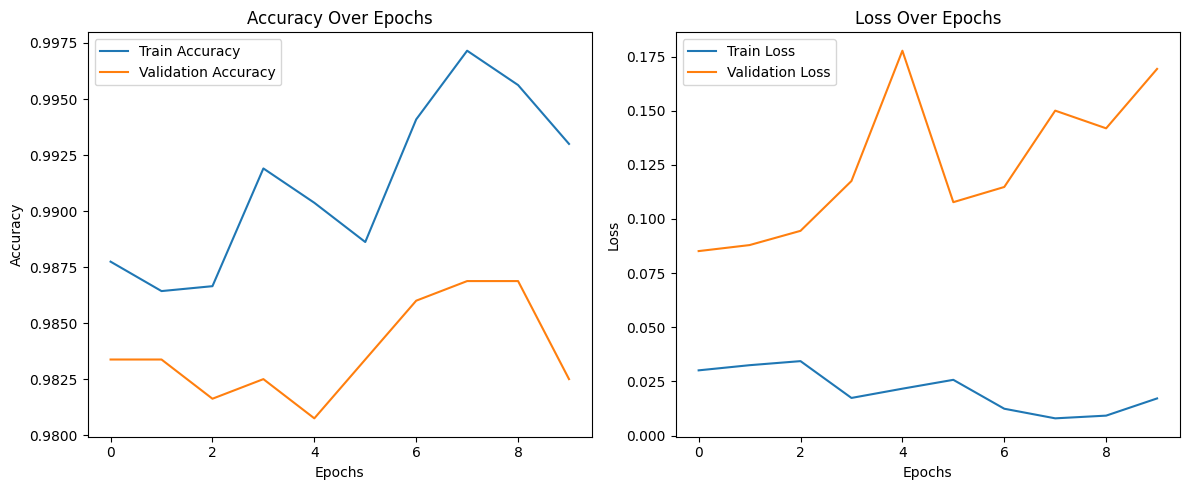

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_accuracy_loss(history):
    # Plotting the training and validation accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

# Train the model and save history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot the accuracy and loss curves
plot_accuracy_loss(history)


## **Use Parallel Process**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load and preprocess the CSV data
csv_path = '/Brain_MRI_Dataset/Brain_MRI_conditions.csv'
csv_data = pd.read_csv(csv_path)

# Basic preprocessing of the CSV dataset
# Keep 'Type', 'Description', and 'Body Part' columns for now
csv_data = csv_data[['Type', 'Description', 'Body Part']]
csv_data.fillna('', inplace=True)

# Encode categorical columns
label_encoders = {}
for col in csv_data.columns:
    le = LabelEncoder()
    csv_data[col] = le.fit_transform(csv_data[col])
    label_encoders[col] = le

# Paths to the tumor and no tumor image folders
tumor_folders = ['/Brain_MRI_Dataset/Training/glioma',
                 '/Brain_MRI_Dataset/Training/meningioma',
                 '/Brain_MRI_Dataset/Training/pituitary']
no_tumor_folder = '/Brain_MRI_Dataset/Training/notumor'

# Function to load and preprocess a single image (helper function)
def process_single_image(file_info):
    folder, filename, label, img_size = file_info
    img_path = os.path.join(folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to 0-1 range
        return img, label
    return None, None

# Function to load and preprocess images from multiple folders in parallel
def load_images_parallel(folders, labels, img_size=(128, 128)):
    images = []
    labels_list = []
    all_files = []

    # Prepare the list of files to process
    for folder, label in zip(folders, labels):
        for filename in os.listdir(folder):
            all_files.append((folder, filename, label, img_size))

    # Use ThreadPoolExecutor to load images in parallel
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_single_image, all_files)

    # Collect valid images and labels from the results
    for img, label in results:
        if img is not None:
            images.append(img)
            labels_list.append(label)

    return np.array(images), np.array(labels_list)

# Load tumor and no tumor images in parallel
tumor_folders_labels = [1] * len(tumor_folders)  # Tumor: label 1
folders = tumor_folders + [no_tumor_folder]
labels = tumor_folders_labels + [0]  # No tumor: label 0

# Load images from tumor and no tumor folders
X_images, y_labels = load_images_parallel(folders, labels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)

# Build a CNN model for image classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: cancer or no cancer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Save the model
model.save('brain_mri_cancer_model.h5')

# To make predictions
def predict_cancer(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    if prediction > 0.5:
        return "Cancer"
    else:
        return "No Cancer"

# Example prediction
new_image_path = '/Brain_MRI_Dataset/Testing/glioma/Te-glTr_0000.jpg'
result = predict_cancer(new_image_path, model)
print(result)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.7823 - loss: 0.4533 - val_accuracy: 0.9580 - val_loss: 0.1297
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9534 - loss: 0.1387 - val_accuracy: 0.9676 - val_loss: 0.0951
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9624 - loss: 0.0980 - val_accuracy: 0.9449 - val_loss: 0.1655
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.9741 - loss: 0.0755 - val_accuracy: 0.9694 - val_loss: 0.0777
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.9811 - loss: 0.0545 - val_accuracy: 0.9764 - val_loss: 0.0649
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.9854 - loss: 0.0409 - val_accuracy: 0.9738 - val_loss: 0.0677
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.9867 - loss: 0.0295 - val_accuracy: 0.9755 - val_loss: 0.0723
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.9929 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Cancer


1.35s

## **Performance Check**

In [ ]:
import time

# Serial version
def load_images_serial(folders, labels, img_size=(128, 128)):
    images = []
    labels_list = []

    for folder, label in zip(folders, labels):
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = img / 255.0  # Normalize to 0-1 range
                images.append(img)
                labels_list.append(label)

    return np.array(images), np.array(labels_list)

# Measure time for serial loading
start_time_serial = time.time()
X_images_serial, y_labels_serial = load_images_serial(folders, labels)
end_time_serial = time.time()
serial_time = end_time_serial - start_time_serial
print(f"Serial execution time: {serial_time:.2f} seconds")


Serial execution time: 60.99 seconds


Parallel execution time: 14.18 seconds
Serial execution time: 27.47 seconds


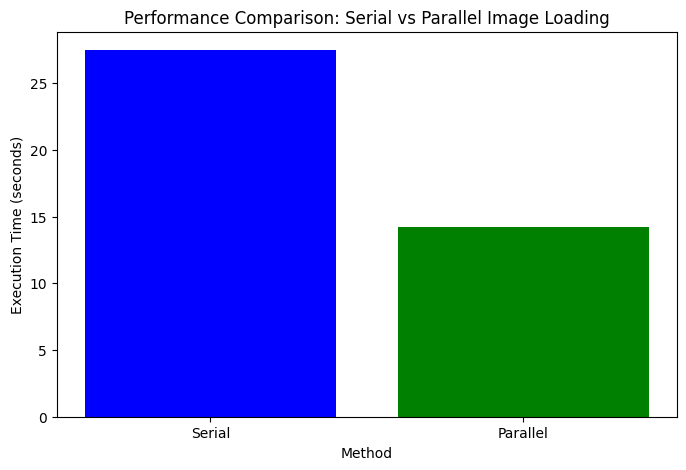

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Load and preprocess the CSV data
csv_path = '/content/drive/MyDrive/Project_Dataset/Brain_MRI_conditions.csv'
csv_data = pd.read_csv(csv_path)

# Basic preprocessing of the CSV dataset
csv_data = csv_data[['Type', 'Description', 'Body Part']]
csv_data.fillna('', inplace=True)

# Encode categorical columns
label_encoders = {}
for col in csv_data.columns:
    le = LabelEncoder()
    csv_data[col] = le.fit_transform(csv_data[col])
    label_encoders[col] = le

# Paths to the tumor and no tumor image folders
tumor_folders = ['/Brain_MRI_Dataset/Training/glioma',
                 '/Brain_MRI_Dataset/Training/meningioma',
                 '/Brain_MRI_Dataset/Training/pituitary']
no_tumor_folder = '/Brain_MRI_Dataset/Training/notumor'

# Function to load and preprocess a single image
def process_single_image(file_info):
    folder, filename, label, img_size = file_info
    img_path = os.path.join(folder, filename)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to 0-1 range
        return img, label
    return None, None

# Function to load images in parallel
def load_images_parallel(folders, labels, img_size=(128, 128)):
    images = []
    labels_list = []
    all_files = []

    for folder, label in zip(folders, labels):
        for filename in os.listdir(folder):
            all_files.append((folder, filename, label, img_size))

    # Use ThreadPoolExecutor to load images in parallel
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_single_image, all_files)

    for img, label in results:
        if img is not None:
            images.append(img)
            labels_list.append(label)

    return np.array(images), np.array(labels_list)

# Measure time for parallel loading
folders = tumor_folders + [no_tumor_folder]
tumor_folders_labels = [1] * len(tumor_folders)  # Tumor: label 1
labels = tumor_folders_labels + [0]  # No tumor: label 0

start_time_parallel = time.time()
X_images_parallel, y_labels_parallel = load_images_parallel(folders, labels)
end_time_parallel = time.time()
parallel_time = end_time_parallel - start_time_parallel
print(f"Parallel execution time: {parallel_time:.2f} seconds")

# Measure time for serial loading
def load_images_serial(folders, labels, img_size=(128, 128)):
    images = []
    labels_list = []

    for folder, label in zip(folders, labels):
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = img / 255.0  # Normalize to 0-1 range
                images.append(img)
                labels_list.append(label)

    return np.array(images), np.array(labels_list)

# Measure time for serial loading
start_time_serial = time.time()
X_images_serial, y_labels_serial = load_images_serial(folders, labels)
end_time_serial = time.time()
serial_time = end_time_serial - start_time_serial
print(f"Serial execution time: {serial_time:.2f} seconds")

# Plot the performance comparison
times = [serial_time, parallel_time]
methods = ['Serial', 'Parallel']

plt.figure(figsize=(8, 5))
plt.bar(methods, times, color=['blue', 'green'])
plt.xlabel('Method')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance Comparison: Serial vs Parallel Image Loading')
plt.show()


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
# Enable mixed precision if supported
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
